# Only Tablar Model

# Imports

In [3]:
import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.ensemble import VotingClassifier

import catboost as cb
import lightgbm as lgb
from tqdm.auto import tqdm
import gc

import warnings
warnings.simplefilter('ignore')

# Feature Engineering

In [4]:
df_train = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")
df_test = pd.read_csv("/kaggle/input/isic-2024-challenge/test-metadata.csv")

def feature_engineering(df):
    # New features to try...
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df_train["tbp_lv_y"], df_train["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    # Taken from: https://www.kaggle.com/code/dschettler8845/isic-detect-skin-cancer-let-s-learn-together
    df["color_variance_ratio"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_stdLExt"]
    df["border_color_interaction"] = df["tbp_lv_norm_border"] * df["tbp_lv_norm_color"]
    df["size_color_contrast_ratio"] = df["clin_size_long_diam_mm"] / df["tbp_lv_deltaLBnorm"]
    df["age_normalized_nevi_confidence"] = df["tbp_lv_nevi_confidence"] / df["age_approx"]
    df["color_asymmetry_index"] = df["tbp_lv_radial_color_std_max"] * df["tbp_lv_symm_2axis"]
    df["3d_volume_approximation"] = df["tbp_lv_areaMM2"] * np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
    df["color_range"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs() + (df["tbp_lv_A"] - df["tbp_lv_Aext"]).abs() + (df["tbp_lv_B"] - df["tbp_lv_Bext"]).abs()
    df["shape_color_consistency"] = df["tbp_lv_eccentricity"] * df["tbp_lv_color_std_mean"]
    df["border_length_ratio"] = df["tbp_lv_perimeterMM"] / (2 * np.pi * np.sqrt(df["tbp_lv_areaMM2"] / np.pi))
    df["age_size_symmetry_index"] = df["age_approx"] * df["clin_size_long_diam_mm"] * df["tbp_lv_symm_2axis"]
    # Until here.
    
    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index", 
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
        
        "color_variance_ratio", "border_color_interaction", "size_color_contrast_ratio",
        "age_normalized_nevi_confidence", "color_asymmetry_index", "3d_volume_approximation",
        "color_range", "shape_color_consistency", "border_length_ratio", "age_size_symmetry_index",
    ]
    new_cat_cols = ["combined_anatomical_site"]
    return df, new_num_cols, new_cat_cols

num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
]
df_train[num_cols] = df_train[num_cols].fillna(df_train[num_cols].median())
df_train, new_num_cols, new_cat_cols = feature_engineering(df_train.copy())
df_test, _, _ = feature_engineering(df_test.copy())
num_cols += new_num_cols
# anatom_site_general
cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols
train_cols = num_cols + cat_cols

gc.collect()

category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

X_cat = category_encoder.fit_transform(df_train[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_train[cat_col] = X_cat[:, c]


In [5]:
gc.collect()

0

In [6]:
df_train.shape, df_test.shape

((401059, 92), (3, 81))

In [7]:
df_train.head(3)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,color_variance_ratio,border_color_interaction,size_color_contrast_ratio,age_normalized_nevi_confidence,color_asymmetry_index,3d_volume_approximation,color_range,shape_color_consistency,border_length_ratio,age_size_symmetry_index
0,ISIC_0015670,0,IP_1235828,60.0,1,lower extremity,3.04,TBP tile: close-up,1,20.244422,...,0.0,0.0,0.525560,4.380987e-05,0.0,2022.449088,14.608375,0.0,1.478676,107.702857
1,ISIC_0015845,0,IP_8170065,60.0,1,head/neck,1.10,TBP tile: close-up,1,31.712570,...,0.0,0.0,0.220563,2.223838e-09,0.0,1449.793110,14.630380,0.0,0.986739,18.857144
2,ISIC_0015864,0,IP_6724798,60.0,1,posterior torso,3.40,TBP tile: close-up,0,22.575830,...,0.0,0.0,0.540510,4.931962e-06,0.0,4882.849628,17.642050,0.0,1.387282,73.828579


# CV Setup

In [8]:
N_SPLITS = 5
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS)

df_train["fold"] = -1
for idx, (train_idx, val_idx) in enumerate(sgkf.split(df_train, df_train["target"], groups=df_train["patient_id"])):
    df_train.loc[val_idx, "fold"] = idx

# Competition Metric

In [9]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

# LGBM Model

In [8]:
# def objective(trial):
#     param = {
#         "objective": "binary",
#         # "metric": "custom",
#         "verbosity": -1,
#         "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#         "max_depth": trial.suggest_int("max_depth", -1, 50),
#         "min_split_gain": trial.suggest_float("min_split_gain", 0, 1),
#         "subsample": trial.suggest_float("subsample", 0.4, 1.0),
#         "device": "gpu"
#     }
#     scores = []
#     for fold in range(N_SPLITS):
#         _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
#         _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
#         dtrain = lgb.Dataset(_df_train[train_cols], label=_df_train["target"])
#         #dvalid = lgb.Dataset(_df_valid[train_cols], label=_df_valid["target"])
#         gbm = lgb.train(param, dtrain)
#         preds = gbm.predict(_df_valid[train_cols])
#         score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
#         scores.append(score)
#     return np.mean(scores)

In [9]:
# import optuna
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [13]:
# trial.params

In [10]:
new_params = {'boosting_type': 'gbdt',
 'lambda_l1': 2.3714725367089238e-06,
 'lambda_l2': 0.3342935962465335,
 'num_leaves': 95,
 'feature_fraction': 0.8762822033340092,
 'bagging_fraction': 0.5053378628779723,
 'bagging_freq': 1,
 'min_child_samples': 39,
 'learning_rate': 0.051721724658084334,
 'max_depth': 42,
 'min_split_gain': 0.3170338311186489,
 'subsample': 0.7143006980547539}
lgb_scores = []
lgb_models = []
for fold in tqdm(range(N_SPLITS)):
    _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
    _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
    # model = lgb.LGBMClassifier(**new_params)
    model = VotingClassifier([(f"lgb_{i}", lgb.LGBMClassifier(random_state=i, **new_params)) for i in range(3)], voting="soft")
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict_proba(_df_valid[train_cols])[:, 1]
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    lgb_scores.append(score)
    lgb_models.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8762822033340092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8762822033340092
[LightGBM] [Warning] lambda_l2 is set=0.3342935962465335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3342935962465335
[LightGBM] [Warning] lambda_l1 is set=2.3714725367089238e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3714725367089238e-06
[LightGBM] [Warning] bagging_fraction is set=0.5053378628779723, subsample=0.7143006980547539 will be ignored. Current value: bagging_fraction=0.5053378628779723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8762822033340092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8762822033340092
[LightGBM] [Warning] lambda_l2 is set=0

In [11]:
lgbm_score = np.mean(lgb_scores)
print(f"LGBM Score: {lgbm_score:.5f}")

LGBM Score: 0.15705


# LGBM Feature Importances

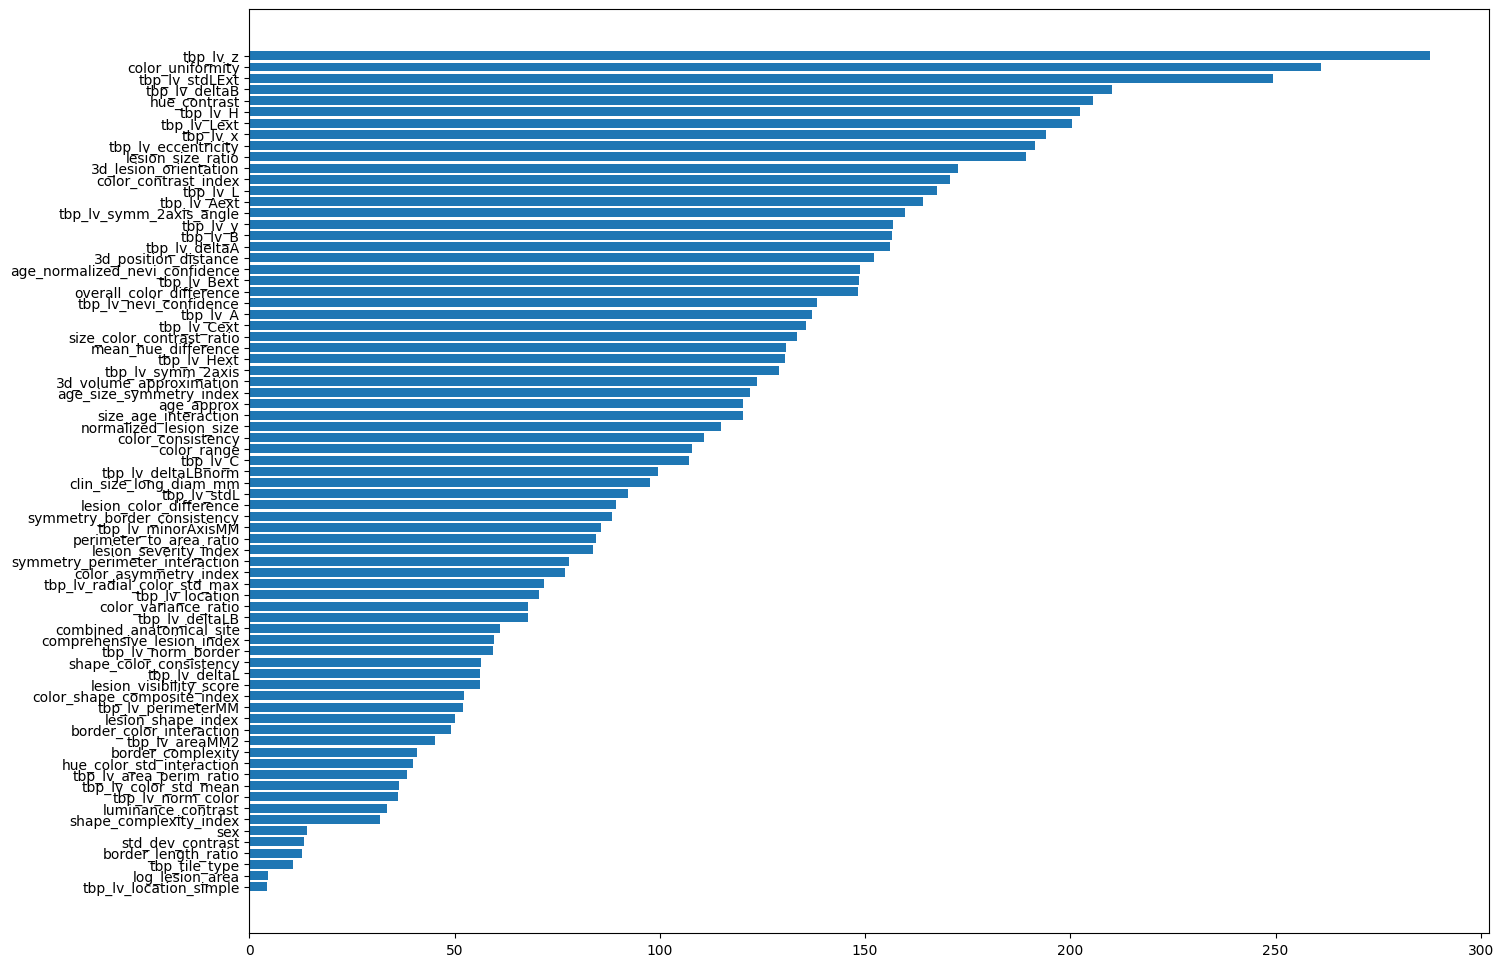

In [12]:
importances = np.mean([estimator.feature_importances_ for model in lgb_models for estimator in model.estimators_ ], 0)
df_imp = pd.DataFrame({"feature": lgb_models[0].estimators_[0].feature_name_, "importance": importances}).sort_values("importance").reset_index(drop=True)
df_imp.to_csv("imp_lgbm.csv", index=False)

plt.figure(figsize=(16, 12))
plt.barh(df_imp["feature"], df_imp["importance"])
plt.show()

In [13]:
X_cat = category_encoder.transform(df_test[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_test[cat_col] = X_cat[:, c]

In [14]:
# inference
lgb_preds = np.mean([model.predict_proba(df_test[train_cols])[:, 1] for model in lgb_models], 0)
#cb_preds = np.mean([model.predict_proba(df_test[train_cols])[:, 1] for model in cb_models], 0)
preds = lgb_preds #* 0.5 + cb_preds * 0.5

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8762822033340092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8762822033340092
[LightGBM] [Warning] lambda_l2 is set=0.3342935962465335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3342935962465335
[LightGBM] [Warning] lambda_l1 is set=2.3714725367089238e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3714725367089238e-06
[LightGBM] [Warning] bagging_fraction is set=0.5053378628779723, subsample=0.7143006980547539 will be ignored. Current value: bagging_fraction=0.5053378628779723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8762822033340092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8762822033340092
[LightGBM] [Warning] lambda_l2 is set=0

In [15]:
df_sub = pd.read_csv("/kaggle/input/isic-2024-challenge/sample_submission.csv")
df_sub["target"] = preds
df_sub

,isic_id,target
0,ISIC_0015657,0.000030
1,ISIC_0015729,0.000018
2,ISIC_0015740,0.000057


In [16]:
df_sub.to_csv("submission.csv", index=False)